# Imports

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
import myOptimizers as optims
import os
import importlib

# Function Definitions

In [2]:
# Weight initialisation
def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Activation function
def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1
    #return np.log(1+np.exp(x))
    #return np.exp(x)

# Returns the NN output AFTER enforcing the boundary condition. This is the wavefunction (wf).
def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    # Enforcing the boundary conditions
    return (1-xTilde)*psi0 + xTilde*psi1 + (1-np.exp(xTilde * (1 - xTilde))) * outputs


dpsi = elementwise_grad(psi, 1) # Function for returning first derivative of wf (not used explicitly)
ddpsi = elementwise_grad(dpsi, 1) # Second derivative of wf. 

In [3]:
PRC1 = 20 # Probability regularisation co-efficient for degree 1 (and -1)
PRC2 = PRC1/(2*2) # Probability regularisation co-efficient for degree 2 (and -2)
PRC3 = PRC2/(2*3) # Probability regularisation co-efficient for degree 3 (and -3)
PRC4 = PRC3/(2*4) # Probability regularisation co-efficient for degree 4 (and -4)


def floatStr (Efloat) :
    Eint = int(np.floor(Efloat))
    if Efloat - Eint == 0 :
        return str(int(np.floor(Efloat)))
    else :
        Estr = str(Efloat)
        return str(int(np.floor(Efloat))) + "p" + Estr[Estr.find('.')+1:]

# Objective function
def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))

    
    #1/(10**8.5)*(1/(E-1.5)**4 + 1/(E-3)**4)
    return np.mean(diffeq**2) + (1-prob)**2 + (PRC1/prob + PRC1*prob) + \
        (PRC2/prob**2 + PRC2*prob**2) + (PRC3/prob**3 + PRC3*prob**3) + \
        (PRC4/prob**4 + PRC4*prob**4) +1/(10**EregCoeffExp)*(1/(E-E1)**EregN + 1/(E-E2)**EregN)


trunc = -1
iterList = []
EregList = []
EregDerList = []
diffeqList = []
diffeqDiffList = []
probList = []
lossList = []
EList = []
# Helper function for callback. Prints the following -
# 1. Iteration no.
# 2. MSE term
# 3. Probability integral
# 4. Loss
# 5. Eigen-energy 
def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']   
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    mean = np.mean(diffeq**2)  # MSE

    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    Ereg = 1/(10**8.5)*(1/(E-1.5)**4 + 1/(E-3)**4)
    #EregDer = -4/(10**8.5)*(1/(E-1.5)**5 + 1/(E-3)**5)
    EregDer = -EregN/(10**EregCoeffExp)*(1/(E-E1)**(EregN+1) + 1/(E-E2)**EregN)
    
    

    loss = mean + (1-prob)**2 + (PRC1/prob + PRC1*prob) + \
        (PRC2/prob**2 + PRC2*prob**2) + (PRC3/prob**3 + PRC3*prob**3) + \
        (PRC4/prob**4 + PRC4*prob**4) + Ereg
    
    iterList.append (step)
    diffeqList.append (mean)
    probList.append (prob)
    lossList.append (loss)
    EregList.append (Ereg)
    EregDerList.append (EregDer)
    EList.append (float(params['E']))

    print ("Iteration " + str(step) + "\ndiffeq = " + str(mean) + " prob = " + str(prob) + \
           " Ereg = " + str(Ereg))
    print ("loss = " + str(loss) + " E = " + str(params['E']))
    print ("EregDer = " + str(EregDer))

# Callback function.
def callback(params, step, g):
    global trunc
    global diffeqList
    
    if step % 100 == 0:
        objectiveDebug (params, step)
        
        if step > 100 :
            if trunc == -1 and np.abs(diffeqDiffList[-1]) < 10**-2 and diffeqDiffList[-1] < 0 :
                trunc = int(step/100)
                print ("Set at index = " + str(trunc))        

# Initialisation

In [4]:
psi0 = 0 # Value of first boundary
psi1 = 0 # Value of second boundary
L = 4 # Length of the well
scale = 2*L # Scale for initialisation
divs = 200 # divisions of the input space

x0 = 0  # Position of first boundary
x1 = L  # Position of second boundary

In [5]:
# Initialising the weights. They usually fall between 0 and 1 which causes the initial wavefunction
# to have a small probability integral over the range. Hence, I've put a scale factor of 2 that changes gives it
# a random (but sizeable) shape so that over the epochs, the probability integral converges to 1.
nnparams = init_random_params(scale/(x1-x0), layer_sizes=[1, 32, 32, 1])

# Intialise a guess eigenvalue to find a true eigenvalue near it
initE = 3.25
params = {'nn': nnparams, 'E': initE}
E1 = 2.5
E2 = 4.0
EregN = 8
#EregCoeffExp = (2 - int(np.ceil(np.log10(E2-E1)))) * (EregN + 3)
EregCoeffExp = (2 - np.log10(E2-E1)) * (EregN + 2)

# Input space
x = np.linspace(x0, x1, divs)[:, None]

# Setting up the name for saving files
name = "L" + floatStr(L) + "E" + floatStr(E1) + "E" + floatStr(initE) + "E" + floatStr(E2)

# Optimization

In [6]:
optims = importlib.reload (optims)
params = optims.myAdam (grad(objective), params, callback=callback, step_size=0.001, diffeqList=diffeqList, probList=probList, diffeqDiffList = diffeqDiffList)

Iteration 100
diffeq = 4.89945486018896 prob = 0.9978002508491696 Ereg = 1.3509253992767091e-06
loss = 56.774699487198966 E = 3.219973924340957
EregDer = -1.2240778991665875e-16
---------------------------------
Iteration 200
diffeq = 2.460469653484478 prob = 0.982016813324784 Ereg = 2.877323170969089e-06
loss = 54.35198866408758 E = 3.1820823063528563
EregDer = -1.6739988101387689e-16
diffeqDiff = -2.4389852067044817
---------------------------------
Iteration 300
diffeq = 1.8054148022013021 prob = 0.9855225148534712 Ereg = 1.1392825079433598e-05
loss = 53.69109293858833 E = 3.129076274382311
EregDer = -3.1293787837618805e-16
diffeqDiff = -0.6550548512831758
---------------------------------
Iteration 400
diffeq = 1.4108691027071398 prob = 0.9926372659343976 Ereg = 0.0002533566119867492
loss = 53.288861792563154 E = 3.059438407958691
EregDer = -8.670045567078988e-16
diffeqDiff = -0.3945456994941623
---------------------------------
Iteration 500
diffeq = 1.1518171304838583 prob = 0.99

Iteration 3300
diffeq = 0.24662138914448184 prob = 0.9975115325307339 Ereg = 5.969882147583594e-08
loss = 52.121932864441305 E = 2.514053487334509
EregDer = -0.2157474235617998
diffeqDiff = -0.0023340198155498426
brkCount2 = 21
---------------------------------
Iteration 3400
diffeq = 0.2441930698181846 prob = 0.9975251605598497 Ereg = 5.972034723925996e-08
loss = 52.11950113942776 E = 2.514100785870687
EregDer = -0.20932096059926217
diffeqDiff = -0.0024283193262972513
brkCount2 = 22
---------------------------------
Iteration 3500
diffeq = 0.24166402737589826 prob = 0.9975390679599581 Ereg = 5.974327245304882e-08
loss = 52.11696864083529 E = 2.5141511331469797
EregDer = -0.20271301006225848
diffeqDiff = -0.002529042442286328
brkCount2 = 23
---------------------------------
Iteration 3600
diffeq = 0.23902741284489998 prob = 0.9975534643303527 Ereg = 5.976774703305323e-08
loss = 52.114328469230365 E = 2.5142048531919086
EregDer = -0.195916868716693
diffeqDiff = -0.0026366145309982825
br

Iteration 6500
diffeq = 0.1087082338096959 prob = 0.9980850678681256 Ereg = 1.1679361960259819e-07
loss = 51.983892656090944 E = 2.5924044915116404
EregDer = -9.39214619246554e-09
diffeqDiff = -0.005846685583482961
brkCount2 = 51
---------------------------------
Iteration 6600
diffeq = 0.10246852962678417 prob = 0.9981262958713303 Ereg = 1.539255236665115e-07
loss = 51.97764513122005 E = 2.6201620047501244
EregDer = -8.832793746148584e-10
diffeqDiff = -0.006239704182911726
brkCount2 = 52
---------------------------------
Iteration 6700
diffeq = 0.09594068952471048 prob = 0.9981778921219431 Ereg = 2.0600865153091454e-07
loss = 51.971107750847786 E = 2.6472272180819503
EregDer = -1.4194157662155195e-10
diffeqDiff = -0.00652784010207369
brkCount2 = 53
---------------------------------
Iteration 6800
diffeq = 0.08923737386324256 prob = 0.9979559039210382 Ereg = 2.754394767298727e-07
loss = 51.964447683129656 E = 2.672164655767827
EregDer = -3.471415485191078e-11
diffeqDiff = -0.0067033156

Iteration 9600
diffeq = 0.0017439372803715698 prob = 0.9999685252032006 Ereg = 1.2548106826553564e-06
loss = 51.87674524179084 E = 2.775891283876286
EregDer = -4.981516274319398e-13
diffeqDiff = -5.272883989856968e-05
brkCount4 = 7
---------------------------------
Iteration 9700
diffeq = 0.0016938206110429384 prob = 0.9999693014567994 Ereg = 1.254750288284201e-06
loss = 51.876695122639845 E = 2.775888584173776
EregDer = -4.981955009322278e-13
diffeqDiff = -5.011666932863137e-05
brkCount4 = 8
---------------------------------
Iteration 9800
diffeq = 0.0017489619859941221 prob = 0.999859608888017 Ereg = 1.254698045345343e-06
loss = 51.87675120558828 E = 2.7758862487190936
EregDer = -4.982334584190138e-13
diffeqDiff = 5.514137495118369e-05
---------------------------------
Iteration 9900
diffeq = 0.001600656127904429 prob = 1.000034391422785 Ereg = 1.254752650788081e-06
loss = 51.87660197021419 E = 2.7758886897836557
EregDer = -4.981937845605535e-13
diffeqDiff = -0.0001483058580896931
br

# Plots

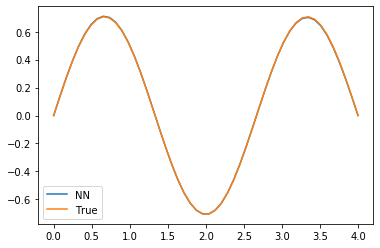

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.linspace(x0, x1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')  # Plotting the NN output
plt.plot (x , np.sqrt(2/L) * np.sin(3*np.pi*x/L), label='True')
plt.legend()
plt.savefig (name + "_plot.png")

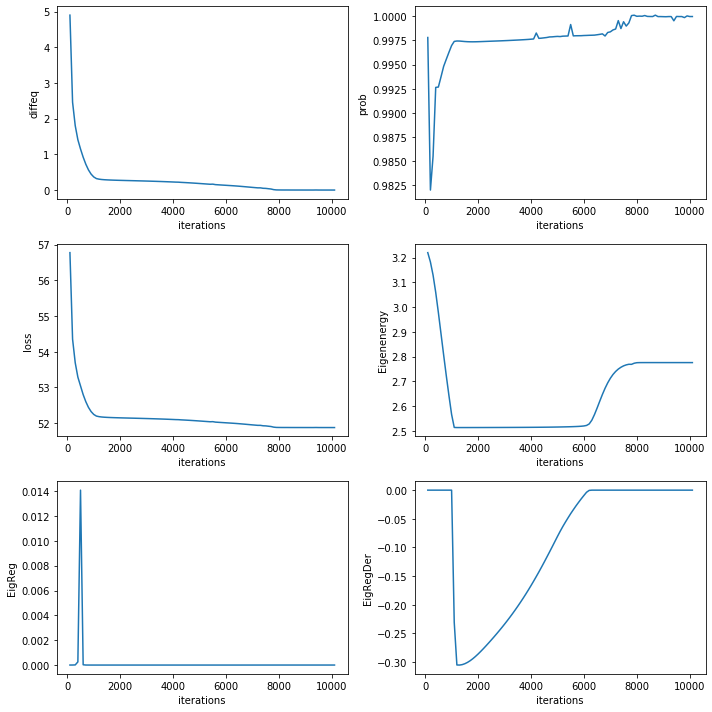

In [8]:
fig = plt.figure (figsize=(10,10))
plt.clf ()

plt.subplot (3 , 2 , 1)
plt.plot (iterList, diffeqList)
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (3, 2, 2)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (3, 2, 3)
plt.plot (iterList, lossList)
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (3, 2, 4)
plt.plot (iterList, EList)
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.subplot (3, 2, 5)
plt.plot (iterList, EregList)
plt.ylabel ('EigReg')
plt.xlabel ('iterations')
plt.tight_layout()

plt.subplot (3, 2, 6)
plt.plot (iterList, EregDerList)
plt.ylabel ('EigRegDer')
plt.xlabel ('iterations')
plt.tight_layout()


plt.savefig (name + "_diagAll.png")

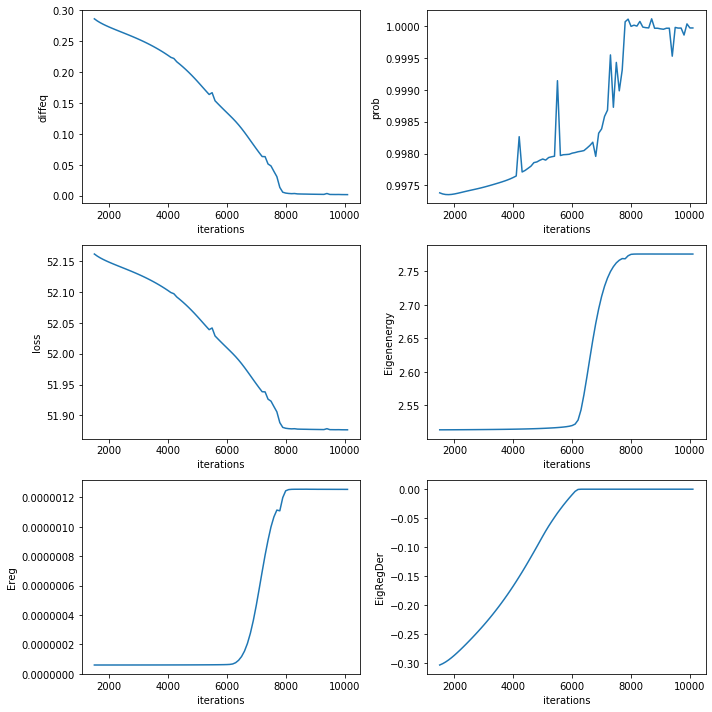

In [9]:
if trunc != -1 :
    fig = plt.figure (figsize=(10,10))

    plt.subplot (3 , 2 , 1)
    plt.plot (iterList[trunc:], diffeqList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeq')

    plt.subplot (3, 2, 2)
    plt.plot (iterList[trunc:], probList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('prob')

    plt.subplot (3, 2, 3)
    plt.plot (iterList[trunc:], lossList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('loss')

    plt.subplot (3, 2, 4)
    plt.plot (iterList[trunc:], EList[trunc:])
    plt.ylabel ('Eigenenergy')
    plt.xlabel ('iterations')
    plt.tight_layout()
    
    plt.subplot (3, 2, 5)
    plt.plot (iterList[trunc:], EregList[trunc:])
    plt.ylabel ('Ereg')
    plt.xlabel ('iterations')
    plt.tight_layout()
    

    plt.subplot (3, 2, 6)
    plt.plot (iterList[trunc:], EregDerList[trunc:])
    plt.ylabel ('EigRegDer')
    plt.xlabel ('iterations')
    plt.tight_layout()


    plt.savefig (name + "_diagTrunc" + str(trunc) + ".png")

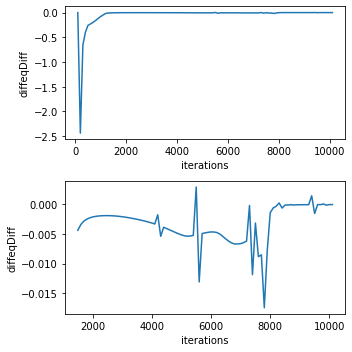

In [10]:
    fig = plt.figure (figsize=(5,5))
    plt.clf ()

    if trunc != -1 :
        plt.subplot (2 , 1 , 1)
        plt.plot (iterList, diffeqDiffList)
        plt.xlabel ('iterations')
        plt.ylabel ('diffeqDiff')

        plt.subplot (2 , 1 , 2)
        plt.plot (iterList[trunc:], diffeqDiffList[trunc:])
        plt.xlabel ('iterations')
        plt.ylabel ('diffeqDiff')
    else :
        plt.plot (iterList, diffeqDiffList)
        #plt.yticks ([min(diffeqDiffList), -10**-4, 10**-4, max(diffeqDiffList)])
        plt.xlabel ('iterations')
        plt.ylabel ('diffeqDiff')

    plt.tight_layout()
    plt.savefig (name + "_diffeqDiff.png")

# Write to file

In [11]:
outfile = open(name + "_info.txt" , "w")

fstr = "diffeq = " + str(round(diffeqList[-1],8)) + \
"\nprob = " + str(round(probList[-1],8)) + \
"\nloss = " + str(round(lossList[-1],8)) + \
"\neigE = " + str(round(EList[-1],8)) + \
"\ndiffeqDiff = " + str(round(diffeqDiffList[-1],8))

    
outfile.write (fstr)
outfile.close ()